# DECISION TREE FOR FOOD 101 HISTOGRAM OF ORIENTED GRADIENTS (HOG) AND COLOR HISTOGRAM EXTRACTION


# Food Image Classification for Nutritional Estimation Refining TEST Model 9


# IMPORTING LIBRARIES

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from skimage.feature import local_binary_pattern
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Check TensorFlow version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


# LOAD FOOD101 TENSORFLOW DATASET & PRINT FIRST 10 FOOD CLASSES

In [2]:
# Load Food-101 dataset
dataset, info = tfds.load("food101", split="train", as_supervised=True, with_info=True)

class_names = info.features["label"].names[:10]
# Get the first 10 class names

# Print information about the dataset
print("First 10 classes:", class_names)
# Print class names of the first 10 classes for confirmation


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.GTD91E_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.GTD91E_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.
First 10 classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


# FUNCTION TO FILTER FOOD101  MATCHING THE FIRST 10 CLASS NAMES SELECTED

In [3]:
# Measure training time for runtime performance
start_time = time.time()

# Function to filter dataset to only the first 10 classes

def filter_classes(image, label):
  # paremter image and label for labeling each food image class

    return label < 10
    # Keep only images where label is between 0 and 9 (first 10 classes)

# Apply filter to remove unwanted classes in FOOD 101 dataset
filtered_dataset = dataset.filter(filter_classes)

# Count dataset size to ensure same size across. SUM of all 1s
dataset_size = sum(1 for _ in filtered_dataset)

# print total images in filtered dataset
print(f"Total images in first 10 classes: {dataset_size}")

Total images in first 10 classes: 7500


# DISPLAY ONE  IMAGE PER UNIQUE FOOD CLASS

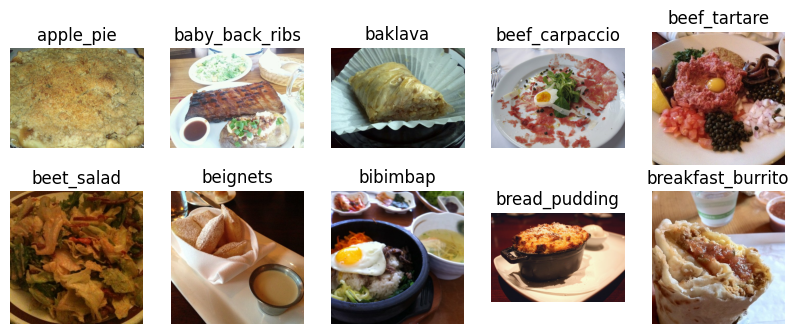

In [4]:
# Dictionary to store one image per class
class_images = {}

# for loop to iterate through filtered 10 classes dataset
for image, label in filtered_dataset:
  # for each image and class label

    label_value = label.numpy()
    # for converting the tensorflow tensor label to python numpy integer
    # integer is need for the indexing in teh dictionary

    # interating through the dictionary storing the first images for each unique food classs label
    if label_value not in class_images:
    # if the integer as the label is not in the dictionary

        class_images[label_value] = image
        # aasign an image from the dataset corresponding uniquely to the dictionary stored food class labels

    if len(class_images) == 10:
    # Stop when we have one image per class coreresponding to each food class
        break

# Plot images
plt.figure(figsize=(10, 10))
# creating a new figure with 10 inches width and height

# iteraing over each key- value pair (class label and an image)
for i, (label, image) in enumerate(sorted(class_images.items())):
    # sorting the items in order and enumerating

    plt.subplot(5, 5, i + 1)
    # subplot in figure for 5 rows and 5 columns

    plt.imshow(image.numpy())
    # displays the image subplot
    # converting the tensorflow tensor image to python numpy integer for matplotlib

    plt.title(class_names[label])
    # sets the title of each plot to the label of each class name

    plt.axis("off")
    # removes axis ticks

plt.show()
# displays complete figure

# DATASET PREPARATION: Split into Train & Validation Sets

In [5]:
# Define train-validation split (80-20)
train_split = 0.8
# 80% for training

train_size = int(train_split * dataset_size)
# the defined split 0.8 multiplied by the dataset size, ensured to return integer and stored in train_size variable

# Split the dataset
# train set
train_ds = filtered_dataset.take(train_size)
# take () method extracts the train_size from the filtered dataset, 80% of filtered dataset

# validation set
val_ds = filtered_dataset.skip(train_size)
# skip () method ignores the train_size from the filtered dataset, remaining 20% of filtered dataset used for validation
# remaining 20% sample from dataset

print(f"Training set size: {train_size}")
print(f"Validation set size: {dataset_size - train_size}")

Training set size: 6000
Validation set size: 1500


# DATASET PREPROCESSING: Resizing image and normalisation

In [6]:
def preprocess(image, label):
    # Ensure the image has 3 dimensions (height, width, channels)
    if len(image.shape) == 2:  # Grayscale image (height, width)
        image = tf.expand_dims(image, axis=-1)  # Add channel dimension
    elif len(image.shape) == 3 and image.shape[-1] == 1:  # Single-channel grayscale
        image = tf.image.grayscale_to_rgb(image)  # Convert to 3 channels

    # Ensure the image has 3 channels
    if image.shape[-1] != 3:
        image = tf.image.grayscale_to_rgb(image)

    # Resize to 64x64 and normalize pixel values
    image = tf.image.resize(image, (64, 64)) / 255.0

    return image, label

# Apply preprocessing and batching
train_ds = train_ds.map(preprocess).batch(32)
val_ds = val_ds.map(preprocess).batch(32)

# Checking Image Shapes

In [7]:

# Check the shape of images
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("First image shape:", images[0].shape)
    print("Image data type:", images.dtype)
    print("First few pixel values:", images[0,0,0:5])

Image batch shape: (32, 64, 64, 3)
First image shape: (64, 64, 3)
Image data type: <dtype: 'float32'>
First few pixel values: tf.Tensor(
[[0.34607843 0.11862745 0.09313726]
 [0.3156863  0.1245098  0.11372549]
 [0.18333334 0.0882353  0.10098039]
 [0.6068627  0.57058823 0.622549  ]
 [0.7117647  0.6901961  0.75490195]], shape=(5, 3), dtype=float32)


# LOAD DECISION TREE MODEL

In [8]:
# Create and train decision tree
dt_classifier = DecisionTreeClassifier(random_state=42)

print ('decision tree model loaded.')

decision tree model loaded.


# DATASET PREPROCESSING: Feature extraction using HOG and COLOR Histogram

## This feature extarction combines both method to have a richer representation of features.


In [53]:
def extract_combined_features(dataset):
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        batch_images = batch_images.numpy()
        batch_labels = batch_labels.numpy()

        for i in range(len(batch_images)):
            img = batch_images[i]

            # ------------------
            # Color Histogram Extraction:
            # For each channel, we compute a histogram with 8 bins over the range [0,1]
            r_hist = np.histogram(img[:, :, 0], bins=8, range=(0, 1))[0]
            g_hist = np.histogram(img[:, :, 1], bins=8, range=(0, 1))[0]
            b_hist = np.histogram(img[:, :, 2], bins=8, range=(0, 1))[0]
            color_features = np.concatenate([r_hist, g_hist, b_hist])

            # ------------------
            # HOG Feature Extraction:
            # Convert to grayscale using a standard luminance conversion.
            gray = np.dot(img, [0.2989, 0.5870, 0.1140])
            hog_features = hog(gray,
                               pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2),
                               feature_vector=True)

            # Combine the features: note that color and HOG features are quite different:
            # - Color features focus on overall color distribution.
            # - HOG features capture local edge and gradient structures.
            combined_features = np.concatenate([color_features, hog_features])

            features.append(combined_features)
            labels.append(batch_labels[i])

    return np.array(features), np.array(labels)

# Extract combined features for training and validation
X_train, y_train = extract_combined_features(train_ds)
X_val, y_val = extract_combined_features(val_ds)

print("All features have been extracted.")
print("Combined feature vector size:", X_train.shape[1])

All features have been extracted.
Combined feature vector size: 1788


# Select Kbest and RFE - (Recursive Feature Elimination) For Feature Selection



In [86]:
# Step 1: SelectKBest - Remove weak features
selector = SelectKBest(f_classif, k=20)  # Keep top 300 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)

# Step 2: RFE - Recursive Feature Elimination
rfe = RFE(dt_classifier, n_features_to_select=5)  # Keep top 200 features
X_train_final = rfe.fit_transform(X_train_selected, y_train)
X_val_final = rfe.transform(X_val_selected)

print("Combined feature vector size:", X_train_selected.shape[1])

Combined feature vector size: 20


# Hyperparameter Tuning for Decision Trees GridSearch CV


In [87]:
# We'll use GridSearchCV to try different hyperparameters for the Decision Tree
# param_grid = {
    # 'max_depth': [5, 10, 15],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
# }


# Decision Tree Hyperparameters 2
# To reduce overfitting of models

param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 50],  # Higher values reduce overfitting
    'min_samples_leaf': [5, 10, 20],  # Increase min_samples_leaf
    'ccp_alpha': [0.001, 0.01, 0.1]
}

# Training the decision tree

In [88]:
# Train the Decision Tree classifier
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_final, y_train)

print("Best parameters found:", grid_search.best_params_)
best_dt = grid_search.best_estimator_

# Calculate training time
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

# Get feature importance scores
importance_scores = best_dt.feature_importances_

# Print the scores
for i, score in enumerate(importance_scores):
    print(f"Feature {i}: Importance Score = {score}")


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found: {'ccp_alpha': 0.001, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10}
Training time: 10371.12 seconds
Feature 0: Importance Score = 0.4027091049421181
Feature 1: Importance Score = 0.1520731770885044
Feature 2: Importance Score = 0.1889447108611316
Feature 3: Importance Score = 0.15512876256920988
Feature 4: Importance Score = 0.10114424453903605


# Evaluation and Prediction

In [89]:
# Predictions
# Evaluate on training data
y_train_pred = best_dt.predict(X_train_final)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Evaluate on validation data
y_val_pred = best_dt.predict(X_val_final)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print accuracy
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Train Accuracy: 0.217
Validation Accuracy: 0.204


# Further Evaluation, Predictions and Peformance Calculation.


In [90]:
# Calculate loss (for example, using log_loss)
y_train_prob = best_dt.predict_proba(X_train_final)
y_val_prob = best_dt.predict_proba(X_val_final)
train_loss = log_loss(y_train, y_train_prob)
val_loss = log_loss(y_val, y_val_prob)
print(f"Train loss: {train_loss:.4f}\n")
print(f"Validation loss: {val_loss:.4f}\n")


# Get classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=class_names))
print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)

Train loss: 2.1437

Validation loss: 2.1831


Classification Report:
                   precision    recall  f1-score   support

        apple_pie       0.00      0.00      0.00       152
   baby_back_ribs       0.24      0.27      0.26       135
          baklava       0.18      0.36      0.24       138
   beef_carpaccio       0.21      0.05      0.08       155
     beef_tartare       0.17      0.25      0.21       157
       beet_salad       0.15      0.41      0.22       144
         beignets       0.22      0.24      0.23       170
         bibimbap       0.43      0.37      0.40       166
    bread_pudding       0.00      0.00      0.00       144
breakfast_burrito       0.11      0.08      0.09       139

         accuracy                           0.20      1500
        macro avg       0.17      0.20      0.17      1500
     weighted avg       0.18      0.20      0.18      1500

Train Accuracy: 0.217
Validation Accuracy: 0.204


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Visualize metrics: Confusion matrix

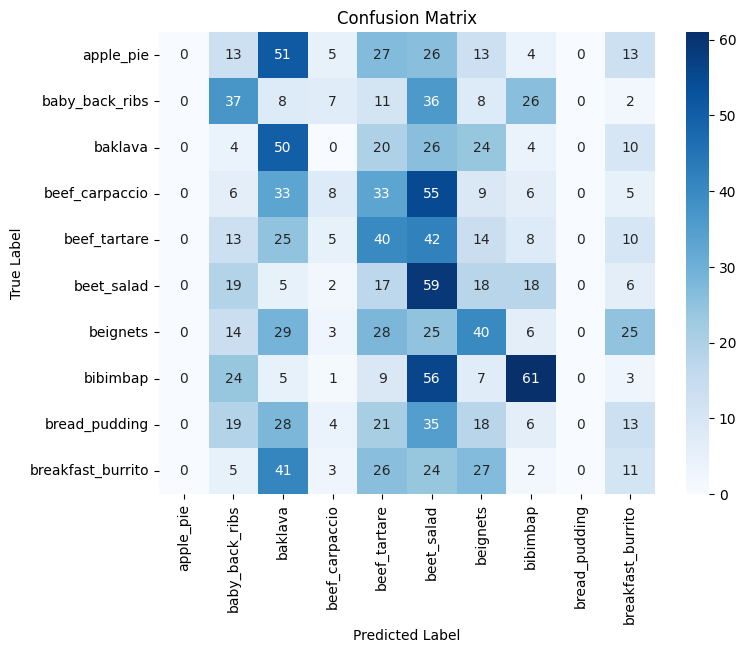

In [91]:
# Calculate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# 2. Plot confusion matrix
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize metrics: Depth vs. Accuracy plot (to tune the model)

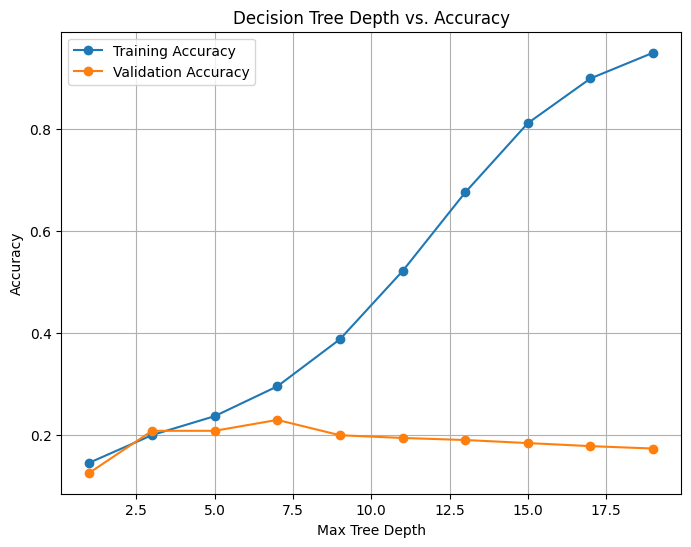

In [92]:
# 5. Depth vs. Accuracy plot (to tune the model)
# This shows how accuracy changes with tree depth
max_depths = [d for d in range(1, 21, 2)]
train_scores = []
val_scores = []

for depth in max_depths:
    dt_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_temp.fit(X_train_final, y_train)
    train_scores.append(accuracy_score(y_train, dt_temp.predict(X_train_final)))
    val_scores.append(accuracy_score(y_val, dt_temp.predict(X_val_final)))

plt.figure(figsize=(8, 6))
plt.plot(max_depths, train_scores, 'o-', label='Training Accuracy')
plt.plot(max_depths, val_scores, 'o-', label='Validation Accuracy')
plt.xlabel('Max Tree Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Depth vs. Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Visualize metrics: Accuracy and loss

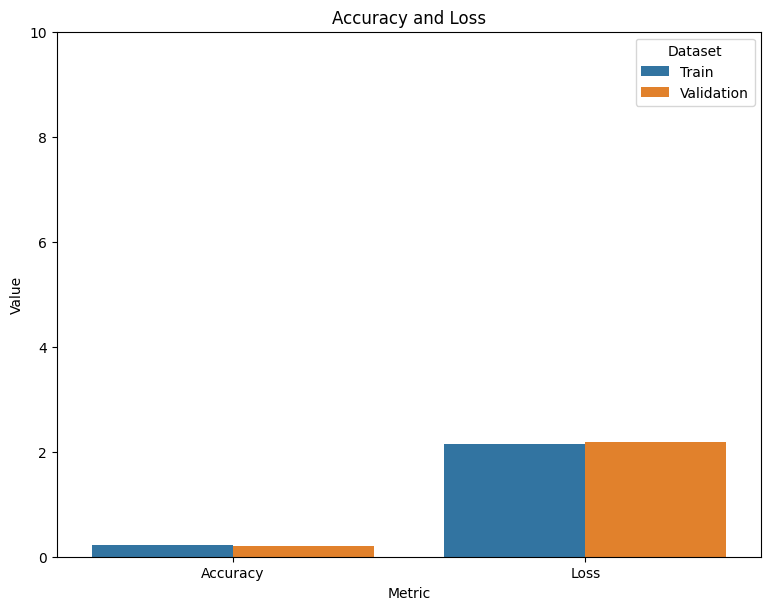

In [93]:
plt.figure(figsize=(20, 15))
plt.subplot(2, 2, 1)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Loss'],
    'Train': [train_accuracy, train_loss],
    'Validation': [val_accuracy, val_loss]
})
metrics_melted = pd.melt(metrics, id_vars=['Metric'], var_name='Dataset', value_name='Value')
sns.barplot(x='Metric', y='Value', hue='Dataset', data=metrics_melted)
plt.title('Accuracy and Loss')

plt.ylim(0,10)
plt.show()

# Visualize metrics: Precision, Recall, f1-score

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x600 with 0 Axes>

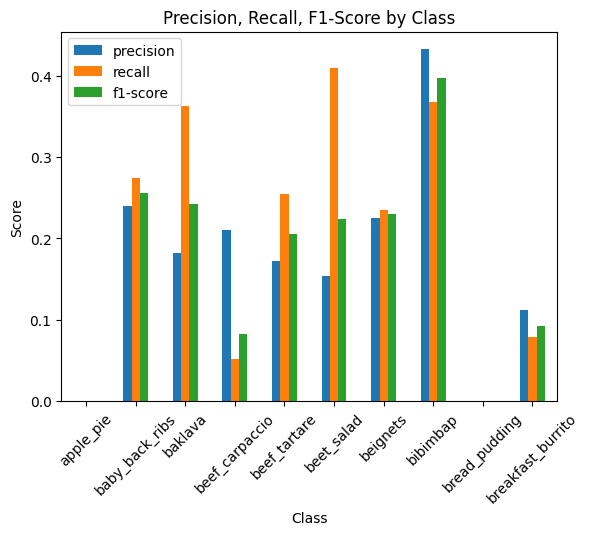

In [94]:
# 3. Plot precision, recall, f1-score
# Convert classification report to DataFrame for visualization
report_dict = classification_report(y_val, y_val_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report_dict).T
report_df = report_df.iloc[:-3]  # Remove support and avg rows if present

plt.figure(figsize=(10, 6))
metrics_df = report_df[['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar')
plt.title('Precision, Recall, F1-Score by Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

# Visualize metrics: Plot runtime performance

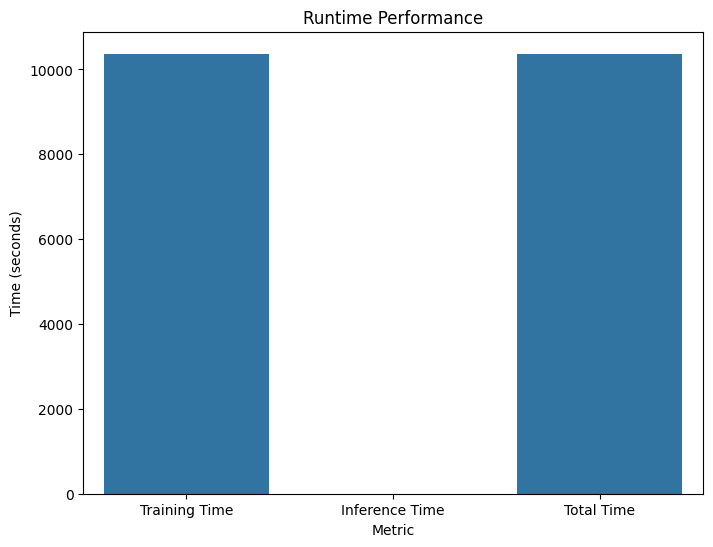

In [95]:
# 4. Plot runtime performance
# Here we show the runtime performance for training and inference
# Note: For demonstration, we use the grid search training time and a quick inference time measurement

inference_start = time.time()
_ = best_dt.predict(X_val_final)
inference_time = time.time() - inference_start

performance = pd.DataFrame({
    'Metric': ['Training Time', 'Inference Time', 'Total Time'],
    'Time (seconds)': [train_time, inference_time, train_time + inference_time]
})
plt.figure(figsize=(8, 6))
sns.barplot(x='Metric', y='Time (seconds)', data=performance)
plt.title('Runtime Performance')
plt.ylabel('Time (seconds)')
plt.show()

# Runtime Performance Summary

In [96]:
# Runtime performance summary
runtime_summary = {
    'Total Images': len(y_train) + len(y_val),
    'Training Time (s)': train_time,
    'Inference Time (s)': inference_time,
    'Images per Second (Training)': len(y_train) / train_time,
    'Images per Second (Inference)': len(y_val) / inference_time
}

print("\nRuntime Performance Summary:")
for key, value in runtime_summary.items():
    print(f"{key}: {value}")


Runtime Performance Summary:
Total Images: 7500
Training Time (s): 10371.116572380066
Inference Time (s): 0.0010361671447753906
Images per Second (Training): 0.5785298003475301
Images per Second (Inference): 1447642.8900138058
